In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import xarray as xa
import pandas as pd
import seaborn as sb
from corner import corner
from pytransit.orbits import epoch
from pytransit.contamination.plotting import _jplot, joint_marginal_plot, plot_kdist, plot_two_sided_kde

from src.core import *

In [3]:
AACW = 3.46
AAPW = 7.1

In [4]:
from astropy.units import AU, Rsun, Rjup, Rearth
from pytransit.orbits import as_from_rhop, i_from_ba, d_from_pkaiews, epoch

def derive_qois(df_original, rstar, star_teff):
    df = df_original.copy()
    ns = df.shape[0]

    rstar_d = normal(rstar.n, rstar.s, size=ns) * Rsun
    period = df.p.values if 'p' in df.columns else df.pr.values

    df['period'] = period
    df['k_true'] = sqrt(df.k2_true)
    df['k_app'] = sqrt(df.k2_app)
    df['cnt'] = 1. - df.k2_app / df.k2_true
    df['a_st'] = as_from_rhop(df.rho.values, period)
    df['a_au'] = df.a_st * rstar_d.to(AU)
    df['inc'] = degrees(i_from_ba(df.b.values, df.a_st.values))
    df['t14'] = d_from_pkaiews(period, df.k_true.values, df.a_st.values, radians(df.inc.values), 0.0, 0.0, 1)
    df['t14_h'] = 24 * df.t14

    df['r_app'] = df.k_app.values * rstar_d.to(Rearth)
    df['r_true'] = df.k_true.values * rstar_d.to(Rearth)

    df['r_app_rsun'] = df.k_app.values * rstar_d.to(Rsun)
    df['r_true_rsun'] = df.k_true.values * rstar_d.to(Rsun)
    df['teff_p'] = Teq(normal(star_teff.n, star_teff.s, size=ns), df.a_st, uniform(0.25, 0.50, ns), uniform(0, 0.4, ns))
    return df

In [5]:
%run toi_2266.py

In [32]:
with xa.load_dataset('TOI-2266.01-joint-contaminated-a.nc') as ds:
    fc = array(ds['mcmc_samples']).reshape([-1, ds.parameter.size])
    df = pd.DataFrame(fc, columns=ds.parameter)
    
with xa.load_dataset('toi-2266.01-joint-achromatic-p2.nc') as ds:
    fc = array(ds['mcmc_samples']).reshape([-1, ds.parameter.size])
    df2 = pd.DataFrame(fc, columns=ds.parameter)
    
df = derive_qois(df, star_r, star_teff)

<AxesSubplot:>

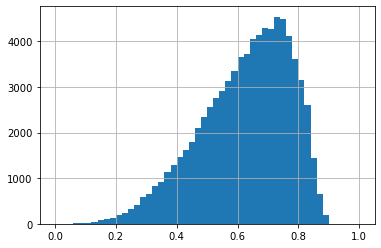

In [33]:
df.cnt.hist(range=(0.00,1.0), bins=50)

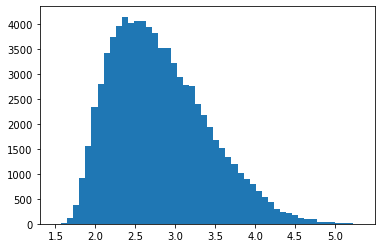

In [34]:
hist(df.r_true, bins=50);

<AxesSubplot:>

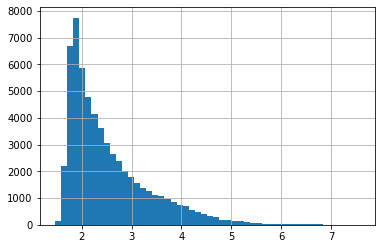

In [21]:
df.r_true.hist(bins=50)

<AxesSubplot:>

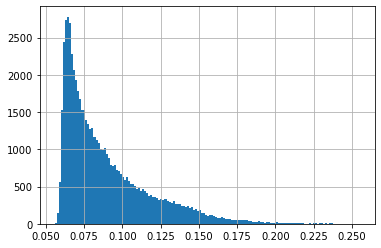

In [25]:
df.k_true.hist(bins=150)

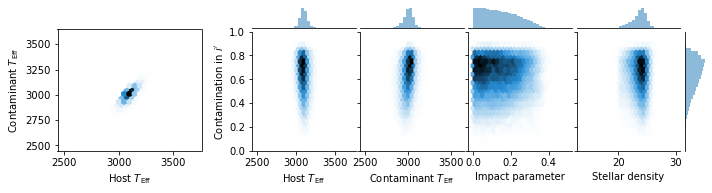

In [35]:
joint_marginal_plot(df, htelim=(2500, 3700), ctelim=(2500,3600), blim=(0, 0.5), rlim=(13.5, 30.0));

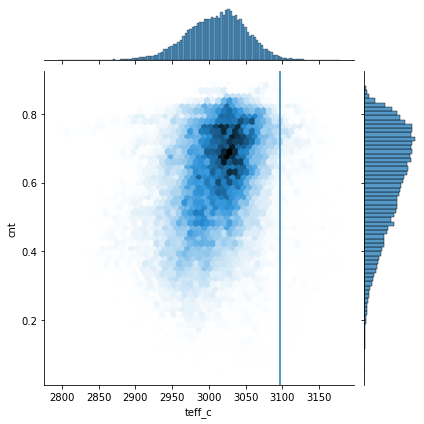

In [30]:
sb.jointplot(df.teff_c, df.cnt, kind='hex')
axvline(df.teff_h.median())

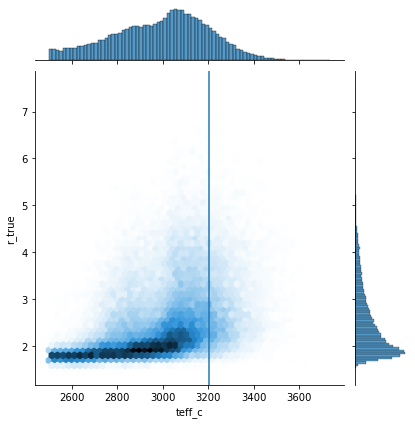

In [67]:
sb.jointplot(df.teff_c, df.r_true, kind='hex')
axvline(df.teff_h.median())

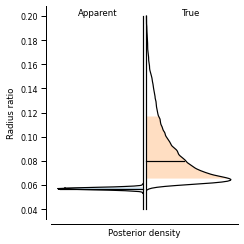

In [29]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, ax = subplots(figsize=(AACW, AACW))
    plot_two_sided_kde(df.k_app, df.k_true, clip=(0.04, 0.2), bw=0.05, ax=ax)
    setp(ax, ylabel='Radius ratio', xlabel='Posterior density', xticks=[])
    ax.text(0.25, 0.99, 'Apparent', ha='center', va='top', transform=ax.transAxes)
    ax.text(0.75, 0.99, 'True', ha='center', va='top', transform=ax.transAxes)
    sb.despine(fig, offset=5)
    fig.tight_layout()
    #fig.savefig('plots/toi_532b_k_posterior.pdf')

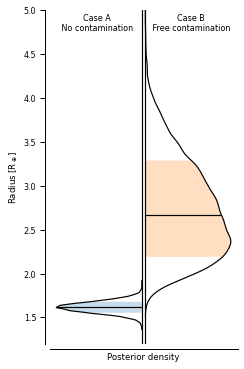

In [31]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, ax = subplots(figsize=(AACW, 1.5*AACW))
    plot_two_sided_kde(df.r_app, df.r_true, clip=(1.2, 5), bw=0.1, ax=ax)
    setp(ax, ylabel='Radius [R$_\oplus$]', xlabel='Posterior density', xticks=[], ylim=(1.2, 5.0))
    ax.text(0.25, 0.99, 'Case A\n No contamination', ha='center', va='top', size=8, transform=ax.transAxes)
    ax.text(0.75, 0.99, 'Case B\n Free contamination', ha='center', va='top', size=8, transform=ax.transAxes)
    sb.despine(fig, offset=5)
    fig.tight_layout()
    #fig.savefig('plots/toi_2266b_radius_posterior.pdf')

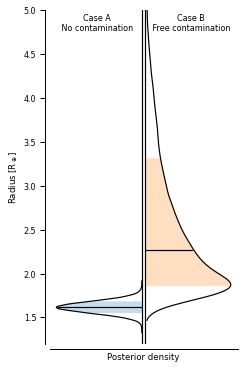

In [64]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, ax = subplots(figsize=(AACW, 1.5*AACW))
    plot_two_sided_kde(df.r_app, df.r_true, clip=(1.2, 5), bw=0.1, ax=ax)
    setp(ax, ylabel='Radius [R$_\oplus$]', xlabel='Posterior density', xticks=[], ylim=(1.2, 5.0))
    ax.text(0.25, 0.99, 'Case A\n No contamination', ha='center', va='top', size=8, transform=ax.transAxes)
    ax.text(0.75, 0.99, 'Case B\n Free contamination', ha='center', va='top', size=8, transform=ax.transAxes)
    sb.despine(fig, offset=5)
    fig.tight_layout()
    fig.savefig('plots/toi_2266b_radius_posterior.pdf')

In [113]:
from astropy.io import fits as pf
from astropy.visualization import simple_norm

In [84]:
hri = pd.read_csv('data/other/TOI2266I-dc20210224-Brgamma_plot.tbl', skiprows=8, skipinitialspace=True)

In [111]:
hrii = pf.getdata('data/other/TOI2266I-dc20210224-Brgamma.fits').astype('d')

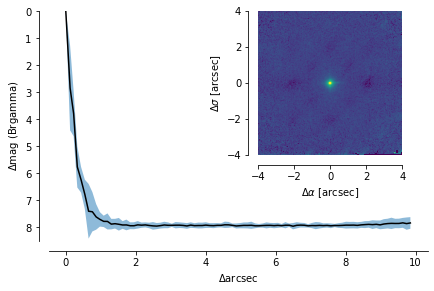

In [155]:
fig, ax = subplots()
ax.fill_between(hri.arcsec, hri.dmag-3*hri.dmrms, hri.dmag+3*hri.dmrms, alpha=0.5)
ax.plot(hri.arcsec, hri.dmag, 'k-')
setp(ax, ylim=(8.5, 0), xlabel='$\Delta$arcsec', ylabel='$\Delta$mag (Brgamma)')
ax2 = axes([0.5, 0.45, 0.5, 0.5])
ax2.imshow(hrii, norm=simple_norm(hrii, stretch='log', min_percent=25, max_percent=99.99), extent=(-4, 4, -4, 4))
setp(ax2, xlabel=r'$\Delta\alpha$ [arcsec]', ylabel=r'$\Delta\sigma$ [arcsec]')
fig.tight_layout()
sb.despine(fig, offset=10)
fig.savefig('plots/TOI2266-hri.pdf')